# Make plots of active zonal near surface temperature

These plot will summarize them using matplotlib to generate the graphs and compute the averages.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as py
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import xesmf as xe
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

Function(s) to compute the weighted mean for a DataArray

In [2]:
def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataArray
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average xarray
    """

    if mask is not None:
        wgt=weight*abs(mask)
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    elif weights is not None:
        wgt=weight
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average

Function to compute the weighted mean for DataArrays in a DataSet

In [3]:
def masked_average_ds(xs=None,
                      vars=None,
                      dim=None,
                      weights:xr.DataArray=None,
                      mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataSet
    :param vars: list of variables
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average for all arrays in a DataSet
    """

    i = 0
    for vv in vars:
        data=xs[vv]
        data_mean = masked_average(data,dim=dim,weights=weights,mask=mask)
        # Add mean to dataset that will hold all means
        if i == 0:
            xs_weighted_average = data_mean.to_dataset(name=vv) 
            i=1
        else:
            xs_weighted_average[vv] = data_mean
    return xs_weighted_average

Function to compute the required ERA5 climatological data

In [4]:
def get_climo(start_year,
              end_year,
              ds_in_full):
    
    # Get the model fields and average them
    print("get_climo")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full['tas'].sel(time=slice(year1, year2))

    # Group the data by seasons, compute the seasonal and zonal means
    month_length = ds_in.time.dt.days_in_month
    weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

    ds_out = (ds_in * weights).groupby("time.season").sum(dim="time").rename('tas').to_dataset()

    #ds = xr.merge([ds_in,dr_zonal],compat="override")
    #ds_out = ds.mean('time')
    
    return ds_out

    

### Compute the zonal and annual means from ERA5 products and CanESM, then generate plots with the information.

In [5]:
file_era5_tas = "/space/hall5/sitestore/eccc/crd/ccrn/users/ncs001/u1_data/canesm5-analysis/cmip6_gmd_figures/input_data/obs/NEIL/era5/era5_tas_monthlymean_1979-2019.nc"

file_canam_grid="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/CanAM5_grid.txt"

file_canesm5_tas = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/tas_Amon_CanESM5_historical_r1i1p2f1_gn_185001-201412.nc"
file_canesm2_tas = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/CanESM/tas_Amon_CanESM2_historical_r1i1p1_185001-200512.nc"

file_areacella="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/areacella_fx_CanAM4_amip_r0i0p0.nc"

start_year=1980
end_year=2005

# Open the datasets
ds_canesm5 = xr.open_dataset(file_canesm5_tas)
ds_canesm2 = xr.open_dataset(file_canesm2_tas)

ds_era5 = xr.open_dataset(file_era5_tas)
ds_areacella = xr.open_dataset(file_areacella)

# Define information needed to regrid the observations
lat_target=ds_canesm5['lat'].values
lon_target=ds_canesm5['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], lat_target),
                     'lon': (['lon'], lon_target),
                    }
                   )

regridder_era5 = xe.Regridder(ds_era5['t2m'],ds_out,'bilinear',periodic=True)

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Interpolate fields as needed

In [6]:
ds_era5_tas = regridder_era5(ds_era5['t2m']).to_dataset().rename({'t2m':'tas'})

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Get the data we need from GOCCP, CanESM2 and CanESM5 for climatologies

In [7]:
ds_era5_climo = get_climo(start_year, end_year, ds_era5_tas)
ds_canesm2_climo = get_climo(start_year, end_year, ds_canesm2)
ds_canesm5_climo = get_climo(start_year, end_year, ds_canesm5)

get_climo
get_climo
get_climo


Create a summary plot

Text(0.055, 0.2, 'SON')

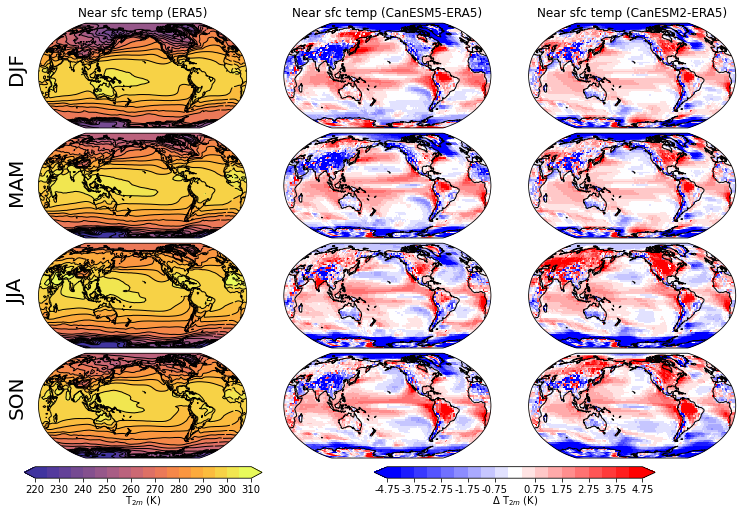

In [8]:
### Show all seasons
# Compute differences
canesm5_diff_djf = ds_canesm5_climo['tas'].sel(season="DJF").to_numpy()-ds_era5_climo['tas'].sel(season="DJF").to_numpy()
canesm5_diff_jja = ds_canesm5_climo['tas'].sel(season="JJA").to_numpy()-ds_era5_climo['tas'].sel(season="JJA").to_numpy()
canesm5_diff_mam = ds_canesm5_climo['tas'].sel(season="MAM").to_numpy()-ds_era5_climo['tas'].sel(season="MAM").to_numpy()
canesm5_diff_son = ds_canesm5_climo['tas'].sel(season="SON").to_numpy()-ds_era5_climo['tas'].sel(season="SON").to_numpy()

canesm2_diff_djf = ds_canesm2_climo['tas'].sel(season="DJF").to_numpy()-ds_era5_climo['tas'].sel(season="DJF").to_numpy()
canesm2_diff_jja = ds_canesm2_climo['tas'].sel(season="JJA").to_numpy()-ds_era5_climo['tas'].sel(season="JJA").to_numpy()
canesm2_diff_mam = ds_canesm2_climo['tas'].sel(season="MAM").to_numpy()-ds_era5_climo['tas'].sel(season="MAM").to_numpy()
canesm2_diff_son = ds_canesm2_climo['tas'].sel(season="SON").to_numpy()-ds_era5_climo['tas'].sel(season="SON").to_numpy()

# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,8])
widths=[1,1,1]
heights=[1,1,1,1]
#gs1 = fig.add_gridspec(4,3,width_ratios=widths,height_ratios=heights,
#                       left=0.085,right=0.95,wspace=0.09,hspace=0.18)
gs1 = fig.add_gridspec(4,3,width_ratios=widths,height_ratios=heights,
                       left=0.07,right=0.92,bottom=0.125,wspace=0.0,
                       hspace=0.05)

f_ax1_1 = fig.add_subplot(gs1[0,0],projection=ccrs.Robinson(central_longitude=200))
f_ax1_2 = fig.add_subplot(gs1[0,1],projection=ccrs.Robinson(central_longitude=200))
f_ax1_3 = fig.add_subplot(gs1[0,2],projection=ccrs.Robinson(central_longitude=200))
f_ax2_1 = fig.add_subplot(gs1[1,0],projection=ccrs.Robinson(central_longitude=200))
f_ax2_2 = fig.add_subplot(gs1[1,1],projection=ccrs.Robinson(central_longitude=200))
f_ax2_3 = fig.add_subplot(gs1[1,2],projection=ccrs.Robinson(central_longitude=200))
f_ax3_1 = fig.add_subplot(gs1[2,0],projection=ccrs.Robinson(central_longitude=200))
f_ax3_2 = fig.add_subplot(gs1[2,1],projection=ccrs.Robinson(central_longitude=200))
f_ax3_3 = fig.add_subplot(gs1[2,2],projection=ccrs.Robinson(central_longitude=200))
f_ax4_1 = fig.add_subplot(gs1[3,0],projection=ccrs.Robinson(central_longitude=200))
f_ax4_2 = fig.add_subplot(gs1[3,1],projection=ccrs.Robinson(central_longitude=200))
f_ax4_3 = fig.add_subplot(gs1[3,2],projection=ccrs.Robinson(central_longitude=200))

#cmap1 = py.get_cmap('cividis')
#cmap1 = py.get_cmap('viridis')
cmapt = cmocean.cm.thermal
cmap1= ListedColormap(cmapt(np.linspace(0.2,1.0,128)))
levels1=np.arange(220,315,5)
norm1 = BoundaryNorm(levels1, ncolors=cmap1.N, clip=True)

cmap2 = py.get_cmap('bwr')
levels2=np.asarray([-4.75,-4.25,-3.75,-3.25,-2.75,-2.25,-1.75,-1.25,-0.75,-0.25,
                   0.25,0.75,1.25,1.75,2.25,2.75,3.25,3.75,4.25,4.75])
#levels2_ticks=np.asarray([-4.25,-3.25,-2.25,-1.25,-0.25,0.25,1.25,2.25,3.25,4.25])
#levels2_ticklabels=np.asarray(['-4.25','-3.25','-2.25','-1.25','-0.25','0.25','1.25','2.25','3.25','4.25'])
levels2_ticks=np.asarray([-4.75,-3.75,-2.75,-1.75,-0.75,0.75,1.75,2.75,3.75,4.75])
levels2_ticklabels=np.asarray(['-4.75','-3.75','-2.75','-1.75','-0.75','0.75','1.75','2.75','3.75','4.75'])

norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

obs_vmin=220
obs_vmax=310
anom_vmin=-5
anom_vmax=5

###################################
# Make the plots
###################################

# Plot the pr from ERA5

f1_1=f_ax1_1.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="DJF"),
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs1_1=f_ax1_1.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="DJF"), 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax1_1.set_title("Near sfc temp (ERA5)")
f_ax1_1.coastlines()

f1_2=f_ax1_2.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm5_diff_djf,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax1_2.set_title("Near sfc temp (CanESM5-ERA5)")
f_ax1_2.coastlines()

f1_3=f_ax1_3.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm2_diff_mam,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax1_3.set_title("Near sfc temp (CanESM2-ERA5)")
f_ax1_3.coastlines()

f2_1=f_ax2_1.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="MAM"),
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs2_1=f_ax2_1.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="MAM"), 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax2_1.coastlines()

f2_2=f_ax2_2.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm5_diff_mam,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax2_2.coastlines()

f2_3=f_ax2_3.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm2_diff_mam,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax2_3.coastlines()

f3_1=f_ax3_1.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="JJA"),
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs3_1=f_ax3_1.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="JJA"), 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax3_1.coastlines()

f3_2=f_ax3_2.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm5_diff_jja,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax3_2.coastlines()

f3_3=f_ax3_3.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm2_diff_jja,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax3_3.coastlines()

f4_1=f_ax4_1.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="SON"),
                        vmin=obs_vmin,vmax=obs_vmax,cmap=cmap1,norm=norm1,shading='auto',transform=ccrs.PlateCarree())
cs4_1=f_ax4_1.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="SON"), 
                      levels=levels1, colors='k',transform=ccrs.PlateCarree(), linewidths=1)
f_ax4_1.coastlines()

f4_2=f_ax4_2.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm5_diff_son,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_2=f_ax1_2.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['tas'].sel(season="DJF"), 
#                  levels=levels1, colors='k', transform=ccrs.PlateCarree(), linewidths=1)
f_ax4_2.coastlines()

f4_3=f_ax4_3.pcolormesh(ds_era5_climo['lon'],ds_era5_climo['lat'],canesm2_diff_son,
                        vmin=anom_vmin,vmax=anom_vmax,cmap=cmap2,norm=norm2,shading='auto',transform=ccrs.PlateCarree())
#cs1_3=f_ax1_3.contour(ds_era5_climo['lon'],ds_era5_climo['lat'],ds_era5_climo['uas'], 10, colors='k',
#                  transform=ccrs.PlateCarree(), linewidths=1)
f_ax4_3.coastlines()

# Add common colorbars
cax1 = py.axes([0.075, 0.09, 0.275, 0.02])
cb1=py.colorbar(f1_1,cax=cax1,orientation='horizontal',ticks=levels1[::2],extend='both')
cb1.set_label(r"T$_{2m}$ (K)",labelpad=-1)

cax2 = py.axes([0.48, 0.09, 0.325, 0.02])
cb2=py.colorbar(f1_2,cax=cax2,orientation='horizontal',ticks=levels2_ticks,extend='both')
cax2.set_xticklabels(levels2_ticklabels)#,rotation=30)
cb2.set_label(r"$\Delta$ T$_{2m}$ (K)",labelpad=-1)

# Add text so it is clear what season is in each row
fig.text(0.055, 0.78, "DJF", fontsize=20,rotation=90)
fig.text(0.055, 0.57, "MAM", fontsize=20,rotation=90)
fig.text(0.055, 0.40, "JJA", fontsize=20,rotation=90)
fig.text(0.055, 0.20, "SON", fontsize=20,rotation=90)